In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

In [2]:
## strange error only on macOS apparently 
## https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
## get data, just Close values
import readcsv
data = readcsv.get_data(cols=['Close']).astype(np.float32)
print(data.shape)

(18628, 54)


In [4]:
## ===== Preprocessing ==============================
## scale all data into interval [0, 1]
import sklearn.preprocessing
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)

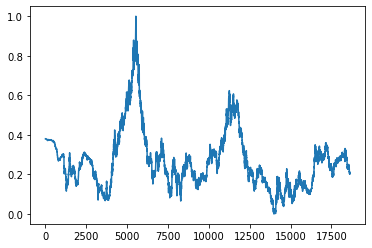

In [5]:
## visualize data
plt.plot(data[:,0])
plt.show()

In [6]:
def generate_batches(data, batch_size, 
                     learn_window=np.arange(50), 
                     predict_window=np.arange(5), 
                     seed=None):
    """
    Randomly generate batches of windows, with replacement.
    
    - data: array, shape = (N, C)
    - batch_size: integer
    - learn_window: array of indices to learn from.
    - predict_window: array of indices to predict.
    - seed: seed for RNG, if any
    
    e.g. if learn_window = [0, 1, 2, ..., 9] and predict_window = [0, 1, 2, 3, 4],
    then learn on 10 days and try to predict next 5 days.
    
    returns: generator that yields random (X, y)
    - X: shape = (B, len(learn_window), C)
    - y: shape = (B, len(predict_window))
    """
    
    if seed != None:
        np.random.seed(seed)
        
    learn_window = np.array(learn_window)
    predict_window = np.array(predict_window)
    
    N, C = data.shape
    L, P = len(learn_window), len(predict_window)
    Lmax, Pmax = int(np.max(learn_window)), int(np.max(predict_window))
    
    X = np.zeros((batch_size, L, C))
    y = np.zeros((batch_size, P))
    
    i = 0   ## tracks index
    k = 0   ## tracks batch size
    M = N - Lmax - Pmax - 1   ## ceiling for i
    while True:
        
        if k == batch_size:
            k = 0
            yield X, y
            
        i = np.random.randint(0, M)
        X[k] = data[i+learn_window]
        y[k] = data[i+Lmax+1+predict_window, 0] ## USD-EUR Close is index 0
        
        k += 1

        
## short test; should not throw error
G = generate_batches(data, 7)

X, y = next(G)
print(X.shape)
print(y.shape)

(7, 50, 54)
(7, 5)


# Predict next day
Should expect good performance since linear regression is pretty good at this.

In [7]:
## split into training and testing sets
data_train = data[:-1000, 0:1]
data_test = data[-1000:, 0:1]
print("Training:", data_train.shape)
print("Testing:", data_test.shape)

Training: (17628, 1)
Testing: (1000, 1)


In [8]:
## ===== model hyperparameters ======================
learn_window = np.arange(30)    ## learn from past 30 days
predict_window = np.arange(1)   ## predict next day

batch_size = 50
initial_learning_rate = 1e-3
# no decay used right now
decay_steps = 300
decay_rate = 0.9
## ==================================================

N, C = data_train.shape
L, P = len(learn_window), len(predict_window)
Lmax, Pmax = int(np.max(learn_window)), int(np.max(predict_window))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
#opt = keras.optimizers.Adam(learning_rate=lr_schedule)
opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)

model_1d = models.Sequential()
model_1d.add(layers.LSTM(64, input_shape=(L, C)))
model_1d.add(layers.Dense(P))
model_1d.compile(optimizer=opt, loss='mse')
model_1d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [9]:
## generate test data
G = generate_batches(data_test, 100, learn_window, predict_window)
X_test, y_test = next(G)

In [11]:
## train on one data point as test
G = generate_batches(data_train, 1, learn_window, predict_window)
X, y = next(G)

model_1d.fit(X, y, batch_size=1)
model_1d.evaluate(X, y, batch_size=1)

Train on 1 samples
1/1 [==============================] - 1s 955ms/sample - loss: 0.1187


0.11865586042404175

In [12]:
## train!
G = generate_batches(data_train, batch_size, learn_window, predict_window, seed=0)

model_1d.fit(G, steps_per_epoch=300, epochs=10, validation_data=(X_test, y_test))

Train for 300 steps, validate on 100 samples
Epoch 1/10
300/300 [==============================] - 31s 103ms/step - loss: 0.0026 - val_loss: 6.6291e-05
Epoch 2/10
300/300 [==============================] - 32s 106ms/step - loss: 1.4982e-04 - val_loss: 5.6376e-05
Epoch 3/10
300/300 [==============================] - 29s 97ms/step - loss: 1.3663e-04 - val_loss: 7.2380e-05
Epoch 4/10
300/300 [==============================] - 26s 87ms/step - loss: 1.1417e-04 - val_loss: 5.0255e-05
Epoch 5/10
300/300 [==============================] - 26s 86ms/step - loss: 1.0394e-04 - val_loss: 4.5352e-05
Epoch 6/10
300/300 [==============================] - 26s 88ms/step - loss: 9.3516e-05 - val_loss: 5.6274e-05
Epoch 7/10
300/300 [==============================] - 26s 86ms/step - loss: 8.7550e-05 - val_loss: 4.3208e-05
Epoch 8/10
300/300 [==============================] - 26s 87ms/step - loss: 7.9005e-05 - val_loss: 4.9019e-05
Epoch 9/10
300/300 [==============================] - 26s 87ms/step - loss: 7

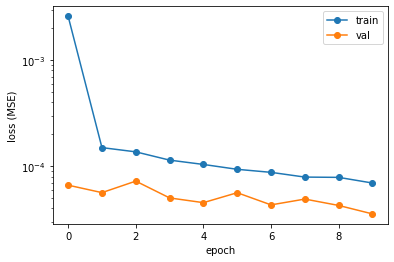

In [13]:
train_loss = model_1d.history.history['loss']
val_loss = model_1d.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

In [17]:
## visualize predictions
X_all = []
y_all = []

N, C = data_test.shape
M = N - Lmax - Pmax - 1   ## ceiling for i

for i in range(M):
    X_all.append(data_test[i+learn_window, 0])
    y_all.append(data_test[i+Lmax+1+predict_window, 0])
    
X_all = np.array(X_all).reshape(M, L, 1)
y_all = np.array(y_all)

y_pred = model_1d.predict(X_all)

Average MSE: 3.060e-05


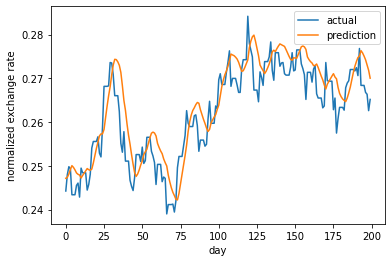

Average MSE: 4.107e-05


In [29]:
## compare actual to 1-day predictions
## pick any date interval, subset of [0, M]
dates = np.arange(0, 200)
#dates = np.arange(0, M)

plt.plot(y_all[dates, 0], label='actual')
plt.plot(y_pred[dates,0], label='prediction')
plt.ylabel('normalized exchange rate')
plt.xlabel('day')
plt.legend()
plt.show()

mse = np.mean(np.square(y_all[:,0] - y_pred[:,0]))
print("Average MSE: %.3e" % mse)

# Predict future trend, only exchange rate
Try to beat linear regression predictions

In [21]:
## split into training and testing sets
data_train = data[:-1000, 0:1]
data_test = data[-1000:, 0:1]
print("Training:", data_train.shape)
print("Testing:", data_test.shape)

Training: (17628, 1)
Testing: (1000, 1)


In [22]:
## ===== model hyperparameters ======================
learn_window = np.arange(100)    ## learn from past 100 days
predict_window = np.arange(0, 30, 3)   ## predict next 30-days (10 trials)

batch_size = 50
initial_learning_rate = 1e-3
decay_steps = 300
decay_rate = 0.9
## ==================================================

N, C = data_train.shape
L, P = len(learn_window), len(predict_window)
Lmax, Pmax = int(np.max(learn_window)), int(np.max(predict_window))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
#opt = keras.optimizers.Adam(learning_rate=lr_schedule)
opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)

model_trend = models.Sequential()
model_trend.add(layers.LSTM(64, input_shape=(L, C)))
model_trend.add(layers.Dense(P))
model_trend.compile(optimizer=opt, loss='mse')
model_trend.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 17,546
Trainable params: 17,546
Non-trainable params: 0
_________________________________________________________________


In [23]:
## generate test data
G = generate_batches(data_test, 100, learn_window, predict_window)
X_test, y_test = next(G)

In [24]:
## train on one data point as test
G = generate_batches(data_train, 1, learn_window, predict_window)
X, y = next(G)

model_trend.fit(X, y, batch_size=1)
model_trend.evaluate(X, y, batch_size=1)

Train on 1 samples
1/1 [==============================] - 1s 873ms/sample - loss: 0.2050


0.20497258007526398

In [25]:
## train!
G = generate_batches(data_train, batch_size, learn_window, predict_window, seed=0)

model_trend.fit(G, steps_per_epoch=300, epochs=10, validation_data=(X_test, y_test))

Train for 300 steps, validate on 100 samples
Epoch 1/10
300/300 [==============================] - 86s 285ms/step - loss: 0.0041 - val_loss: 1.6234e-04
Epoch 2/10
300/300 [==============================] - 69s 232ms/step - loss: 5.3219e-04 - val_loss: 2.6229e-04
Epoch 3/10
300/300 [==============================] - 95s 316ms/step - loss: 5.0472e-04 - val_loss: 1.3764e-04
Epoch 4/10
300/300 [==============================] - 116s 385ms/step - loss: 4.8824e-04 - val_loss: 1.3930e-04
Epoch 5/10
300/300 [==============================] - 109s 363ms/step - loss: 4.7933e-04 - val_loss: 1.4577e-04
Epoch 6/10
300/300 [==============================] - 104s 348ms/step - loss: 4.7276e-04 - val_loss: 1.7659e-04
Epoch 7/10
300/300 [==============================] - 101s 335ms/step - loss: 4.4806e-04 - val_loss: 1.5963e-04
Epoch 8/10
300/300 [==============================] - 106s 353ms/step - loss: 4.4370e-04 - val_loss: 1.4037e-04
Epoch 9/10
300/300 [==============================] - 106s 355ms/s

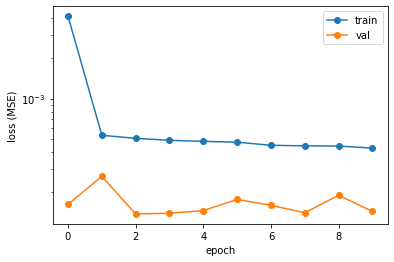

In [26]:
train_loss = model_trend.history.history['loss']
val_loss = model_trend.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

In [37]:
## visualize predictions
X_all = []
y_all = []

detail_window = np.arange(Pmax+1)

N, C = data_test.shape
M = N - Lmax - Pmax - 1   ## ceiling for i

for i in range(M):
    X_all.append(data_test[i+learn_window, 0])
    y_all.append(data_test[i+Lmax+1+detail_window, 0])
    
X_all = np.array(X_all).reshape(M, L, 1)
y_all = np.array(y_all)

y_pred = model_trend.predict(X_all)

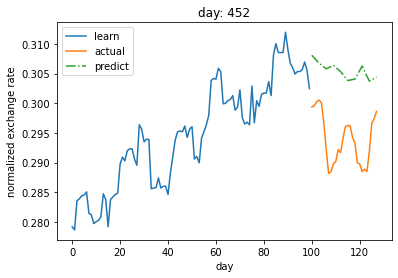

MSE: 1.427e-04


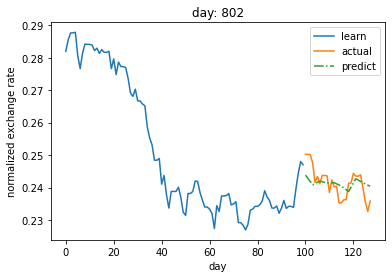

MSE: 1.514e-05


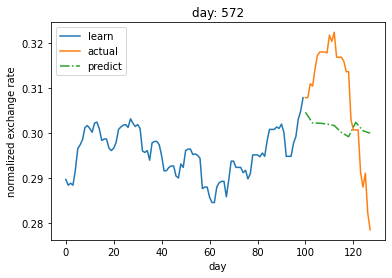

MSE: 2.114e-04


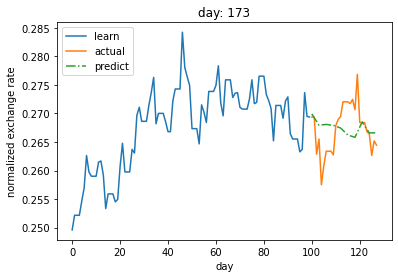

MSE: 1.207e-05


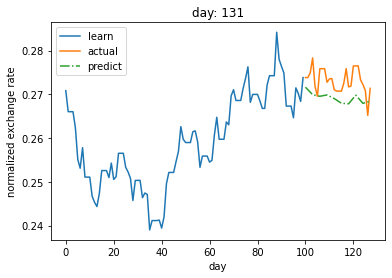

MSE: 2.220e-05


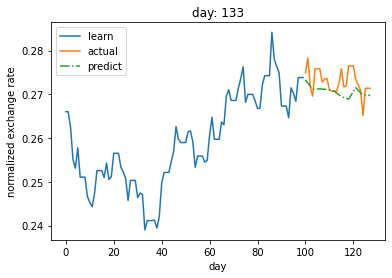

MSE: 1.583e-05


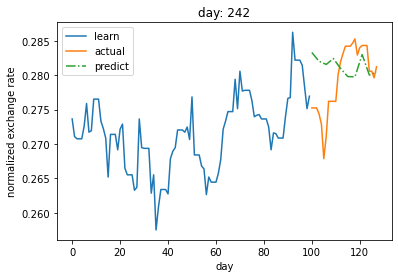

MSE: 3.255e-05


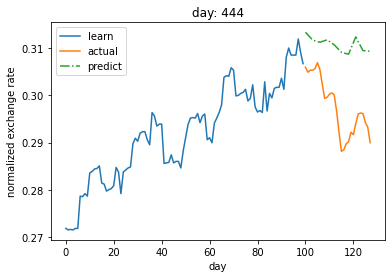

MSE: 2.067e-04


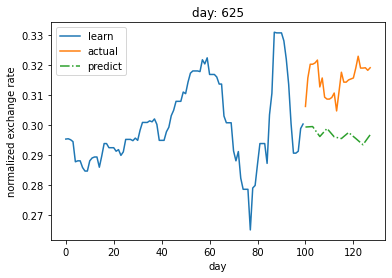

MSE: 3.574e-04


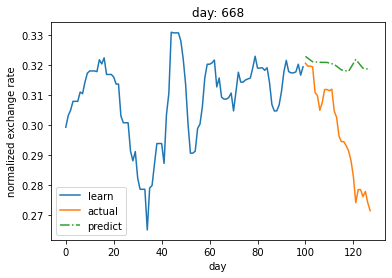

MSE: 8.221e-04


In [57]:
for i in np.random.randint(0, M, size=10):
    
    plt.plot(learn_window, X_all[i, :, 0], label='learn')
    plt.plot(Lmax+1+detail_window, y_all[i, :], label='actual')
    plt.plot(Lmax+1+predict_window, y_pred[i, :], '-.', label='predict')
    plt.title('day: %d' % i)
    plt.ylabel('normalized exchange rate')
    plt.xlabel('day')
    plt.legend()
    plt.show()

    mse = np.mean(np.square(y_all[i, predict_window] - y_pred[i]))
    print("MSE: %.3e" % mse)

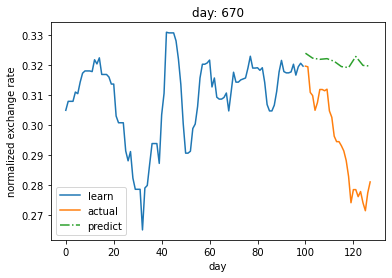

MSE: 8.603e-04


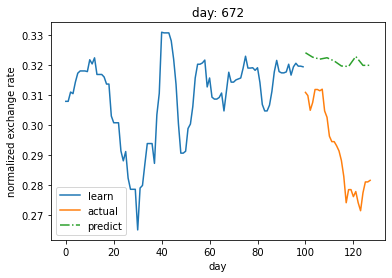

MSE: 9.646e-04


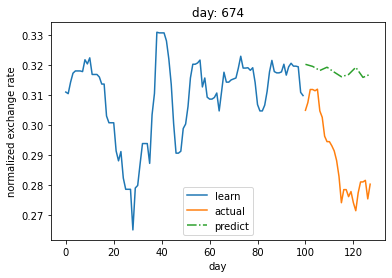

MSE: 1.008e-03


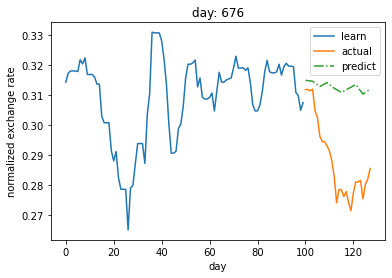

MSE: 7.097e-04


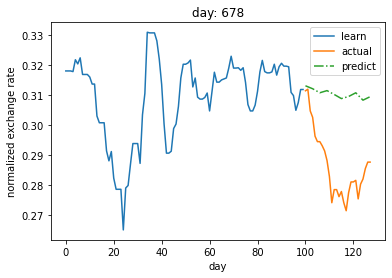

MSE: 5.937e-04


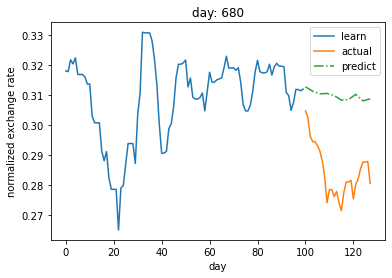

MSE: 7.415e-04


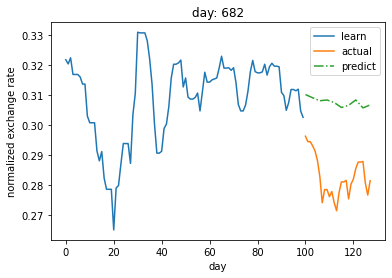

MSE: 6.183e-04


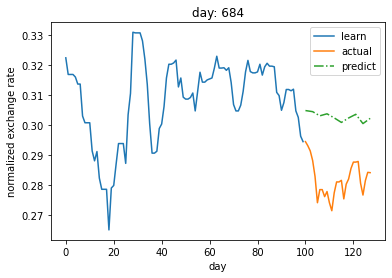

MSE: 4.223e-04


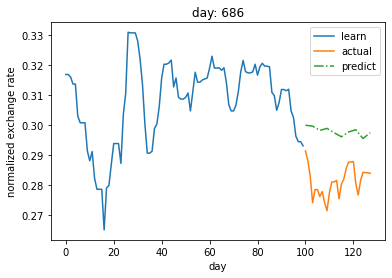

MSE: 3.224e-04


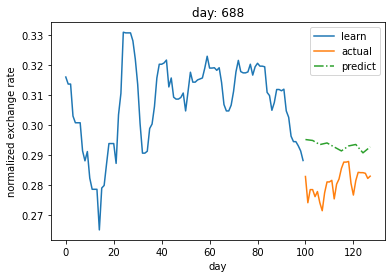

MSE: 1.615e-04


In [60]:
for i in range(670, 690, 2):
    
    plt.plot(learn_window, X_all[i, :, 0], label='learn')
    plt.plot(Lmax+1+detail_window, y_all[i, :], label='actual')
    plt.plot(Lmax+1+predict_window, y_pred[i, :], '-.', label='predict')
    plt.title('day: %d' % i)
    plt.ylabel('normalized exchange rate')
    plt.xlabel('day')
    plt.legend()
    plt.show()

    mse = np.mean(np.square(y_all[i, predict_window] - y_pred[i]))
    print("MSE: %.3e" % mse)

# Testing Code

In [ ]:
def test_generate_batches():
    data = np.arange(1000).reshape(-1, 1)
    print(data.shape)
    
    G = generate_batches(data, 1, history=[0, 10, 20, 30], forecast=[0, 10, 20, 30])
    
    for i in range(10):
        X, y = next(G)
        print(X[0,:,0], y[0])

test_generate_batches()